In [3]:
!wget https://www.statmt.org/europarl/v7/ro-en.tgz
!tar -xf ro-en.tgz
!pip install transformers
!pip install SentencePiece
!pip install nltk bert-score

--2024-05-03 11:26:07--  https://www.statmt.org/europarl/v7/ro-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.32.28
Connecting to www.statmt.org (www.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38180223 (36M) [application/x-gzip]
Saving to: ‘ro-en.tgz’

ro-en.tgz           100%[===================>]  36.41M  9.02MB/s    in 4.0s    

2024-05-03 11:26:12 (9.02 MB/s) - ‘ro-en.tgz’ saved [38180223/38180223]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using c

In [4]:
import os
import re
import random
import string
import pickle
import unicodedata
import numpy as np
import pandas as pd
from io import open
from tqdm import tqdm
from pickle import dump
import matplotlib.pyplot as plt
from unicodedata import normalize

In [5]:
import nltk
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration, AdamW
from __future__ import unicode_literals, print_function, division
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler
from sklearn.model_selection import train_test_split
from torch import optim
from torch.optim import AdamW
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
from torchtext.data.metrics import bleu_score

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {device}')

Running on cuda


In [7]:
def read_file(file_name):
    with open(file_name, mode='rt', encoding='utf-8') as file:
        return file.read()

def process_sentences(text):
    sentences = text.strip().split('\n')
    regex_statement = re.compile('[^%s]' % re.escape(string.printable))
    translation_table = str.maketrans('', '', string.punctuation)

    filtered_sentences = []
    for line in sentences:
        line = normalize('NFD', line).encode('ascii', 'ignore').decode('UTF-8')
        words = [word.lower().translate(translation_table) for word in line.split()]
        words = [regex_statement.sub('', word) for word in words if word.isalpha()]
        filtered_sentences.append(' '.join(words))

    return filtered_sentences

def save_processed_sentences(filtered_sentences, output_filename):
    with open(output_filename, 'wb') as file:
        pickle.dump(filtered_sentences, file)

def process_input_text(file_name, output_filename):
    text = read_file(file_name)
    filtered_sentences = process_sentences(text)
    save_processed_sentences(filtered_sentences, output_filename)
    return filtered_sentences

In [8]:
filtered_sentences1 = process_input_text('europarl-v7.ro-en.en', 'english.pkl')
print("Saved English sentences to english.pkl file")

filtered_sentences2 = process_input_text('europarl-v7.ro-en.ro', 'romanian.pkl')
print("Saved Romanian sentences to romanian.pkl file")

Saved English sentences to english.pkl file
Saved Romanian sentences to romanian.pkl file


In [9]:
def load_vocabulary(english_filename, romanian_filename):
    with open(english_filename, 'rb') as f:
        english_vocabulary = pickle.load(f)
    with open(romanian_filename, 'rb') as f:
        romanian_vocabulary = pickle.load(f)

    return english_vocabulary, romanian_vocabulary

english_vocabulary, romanian_vocabulary = load_vocabulary('english.pkl', 'romanian.pkl')

In [10]:
subset_size = 120000
romanian_subset = romanian_vocabulary[:subset_size]
english_subset = english_vocabulary[:subset_size]

In [11]:
# Pairing input and expected sentences
pairs = list(zip(romanian_subset, english_subset))

# Splitting data into training and validation sets
train_pairs, val_pairs = train_test_split(pairs, test_size=0.20, random_state=42)

# Unpacking training and validation data
train_ro_vocab, train_en_vocab = zip(*train_pairs)
val_ro_vocab, val_en_vocab = zip(*val_pairs)

In [12]:
# Defining a Translation Dataset class
class TranslationDataset(Dataset):
    def __init__(self, tokenizer, inputs, targets, max_len=512):
        self.tokenizer = tokenizer
        self.inputs = inputs
        self.targets = targets
        self.max_len = max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sentence = self.inputs[idx]
        target_sentence = self.targets[idx]

        # Tokenizing input and target sentences
        input_tokens = self.tokenizer(
            input_sentence, max_length=self.max_len, padding='max_length', truncation=True
        )
        target_tokens = self.tokenizer(
            target_sentence, max_length=self.max_len, padding='max_length', truncation=True
        )

        input_ids = input_tokens['input_ids']
        target_ids = target_tokens['input_ids']

        return torch.tensor(input_ids), torch.tensor(target_ids)

In [13]:
from transformers import MarianTokenizer
from transformers import MarianMTModel
modelName = 'Helsinki-NLP/opus-mt-en-ro'
tokenizer = MarianTokenizer.from_pretrained(modelName)
model = MarianMTModel.from_pretrained(modelName)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/789k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/817k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [14]:
# Creating training and validation datasets
train_dataset = TranslationDataset(tokenizer, train_ro_vocab, train_en_vocab)
val_dataset = TranslationDataset(tokenizer, val_ro_vocab, val_en_vocab)

# Creating training and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [15]:
def train(model, train_loader, val_loader, optimizer, device):
    model.train()
    train_loss = 0
    for input_ids, expected_ids in tqdm(train_loader):
        input_ids, expected_ids = input_ids.to(device), expected_ids.to(device)

        outputs = model(input_ids=input_ids, labels=expected_ids)
        loss = outputs.loss
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input_ids, expected_ids in val_loader:
            input_ids, expected_ids = input_ids.to(device), expected_ids.to(device)
            outputs = model(input_ids=input_ids, labels=expected_ids)
            val_loss += outputs.loss.item()

    return train_loss / len(train_loader), val_loss / len(val_loader)

train_losses = []
val_losses = []
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

for epoch in range(num_epochs):
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

100%|██████████| 12000/12000 [33:52<00:00,  5.90it/s]


Epoch 1/3, Training Loss: 0.13231762906738245, Validation Loss: 0.0866261193578442


100%|██████████| 12000/12000 [33:50<00:00,  5.91it/s]


Epoch 2/3, Training Loss: 0.08089387191374166, Validation Loss: 0.0749371480755508


100%|██████████| 12000/12000 [33:49<00:00,  5.91it/s]


Epoch 3/3, Training Loss: 0.06835861480771564, Validation Loss: 0.07044665907975287


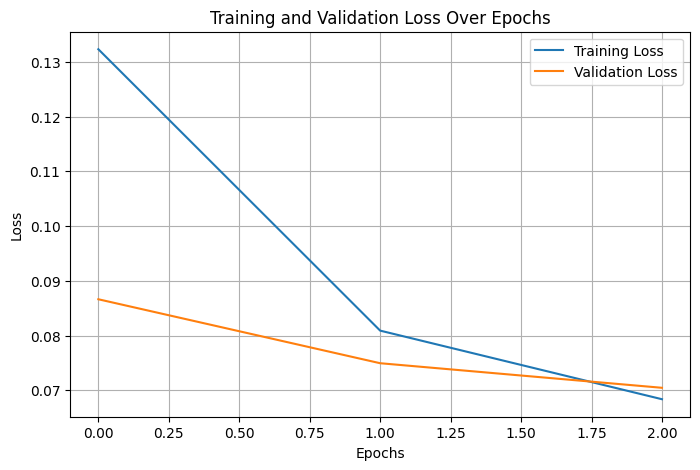

In [16]:
def show_loss_plot(training_losses, validation_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

show_loss_plot(train_losses, val_losses)

In [17]:
torch.save(model.state_dict(), 'marianMT.pth')
with open('marianMT.pkl', 'wb') as file:
    pickle.dump(model, file)

In [18]:
def evaluate_random_samples(model, dataloader, tokenizer, device, num_samples=5):
    model.eval()
    sample_count = 0

    for batch in random.sample(list(dataloader), min(num_samples, len(dataloader))):
        if sample_count >= num_samples:
            break

        input_ids, target_ids = batch
        input_ids, target_ids = input_ids.to(device), target_ids.to(device)

        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids)

        for i in range(input_ids.size(0)):
            if sample_count >= num_samples:
                return

            decoded_input = tokenizer.decode(input_ids[i], skip_special_tokens=True, truncation=True)
            decoded_expected = tokenizer.decode(target_ids[i], skip_special_tokens=True, truncation=True)
            decoded_predicted = tokenizer.decode(outputs[i], skip_special_tokens=True, truncation=True)

            print(f"Romanian: {decoded_input}\nEnglish (Target): {decoded_expected}\nEnglish (Predicted): {decoded_predicted}\n")
            sample_count += 1

evaluate_random_samples(model, val_dataloader, tokenizer, device)

Romanian: europa are prin urmare o responsabilitate deosebita in procesul actual al
English (Target): europe has therefore a particular responsibility in the current process
English (Predicted): europe therefore has a great responsibility in the current process of

Romanian: sa exagerat mult in cele spuse pana acum
English (Target): there has been a great deal of exaggeration in what has been said
English (Predicted): there has been a lot of exaggeration in what has been said so far

Romanian: in numele grupului ppede pl dle presedinte permitetimi sa continui intro limba pe care dna grybauskaito intelege
English (Target): on behalf of the ppede group pl mr president allow me to continue in a language that mrs grybauskaitunderstands
English (Predicted): on behalf of the ppede group pl mr president let me continue in a language that mrs grybauskaito understands

Romanian: solidaritatea intergenerationala implica de asemenea educarea cetatenilor cu privire la respectul pentru viata la dem

In [20]:
import nltk
nltk.download('wordnet')

def translation_metrics_evaluation(model, dataloader, tokenizer, device):
    model.eval()
    expected_sentences_array = []
    target_sentences_array = []

    for batch in dataloader:
        input_ids, expected_ids = batch
        input_ids = input_ids.to(device)

        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids)

        for i in range(input_ids.size(0)):
            decoded_expected = tokenizer.decode(expected_ids[i], skip_special_tokens=True, truncation=True)
            decoded_target = tokenizer.decode(outputs[i], skip_special_tokens=True, truncation=True)

            if decoded_expected and decoded_target:
                expected_sentences_array.append([decoded_expected.split()])
                target_sentences_array.append(decoded_target.split())

    bleu_score = corpus_bleu(expected_sentences_array, target_sentences_array)

    meteor_scores = [meteor_score(esa, tsa) for esa, tsa in zip(expected_sentences_array, target_sentences_array)]
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)

    esas = [' '.join(esa[0]) for esa in expected_sentences_array]
    tsas = [' '.join(tsa) for tsa in target_sentences_array]
    P, R, F1 = bert_score(tsas, esas, lang="en", verbose=True)

    f1_score = F1.mean().item()
    precision = P.mean().item()
    recall = R.mean().item()

    return bleu_score, average_meteor_score, f1_score, precision, recall

bleu_score, Meteor_score, f1_score, precision, recall = translation_metrics_evaluation(model, val_dataloader, tokenizer, device)

[nltk_data] Downloading package wordnet to /root/nltk_data...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/707 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/371 [00:00<?, ?it/s]

done in 75.16 seconds, 315.46 sentences/sec


In [21]:
print(f"BLEU Score: {(bleu_score * 100):.4f}")
print(f"METEOR Score: {(Meteor_score * 100):.4f}")
print(f"F1 Score: {(f1_score * 100):.4f}")
print(f"Precision: {(precision * 100):.4f}")
print(f"Recall: {(recall * 100):.4f}")

BLEU Score: 41.9788
METEOR Score: 70.1402
F1 Score: 95.0854
Precision: 95.1184
Recall: 95.0602
